# Ontology Alignment Experiments: Graph Analysis Pipeline

This notebook demonstrates a complete graph analysis pipeline for ontology alignment:
1. **Exploratory Data Analysis (EDA)** - Understanding the graph structure
2. **Weakly Connected Components (WCC)** - Identifying connected subgraphs
3. **Node Similarity** - Finding similar nodes based on shared properties
4. **Node Embeddings** - Creating vector representations for similarity analysis

In [22]:
# Setup for Google Colab (skip if running locally)
try:
    import google.colab
    import os
    print("📦 Setting up Colab environment...\n")
    GITHUB_URL = "https://github.com/teutaD/EntityMatching-experimentation.git"

    # Clone repository
    !git clone {GITHUB_URL}

    # Check if clone was successful
    if os.path.exists('EntityMatching-experimentation'):
        os.chdir('EntityMatching-experimentation')
        print("✅ Repository cloned successfully\n")
    else:
        raise Exception("Failed to clone repository. Make sure the URL is correct and the repo is public.")

    # Install dependencies
    print("📦 Installing dependencies...")
    !pip install -q neo4j pandas matplotlib seaborn
    print("✅ Setup complete!")

except ImportError:
    print("✅ Running locally - no setup needed")
except Exception as e:
    print(f"❌ Error during setup: {e}")
    print("\n💡 Solutions:")
    print("   1. Make sure your GitHub repository is PUBLIC")
    print("   2. Or use a personal access token for private repos (see Option 2 above)")
    print("   3. Or manually upload the project files using Colab's file browser")

📦 Setting up Colab environment...

fatal: destination path 'EntityMatching-experimentation' already exists and is not an empty directory.
✅ Repository cloned successfully

📦 Installing dependencies...
✅ Setup complete!


## Neo4j Database Setup

**Before running this notebook, you need a Neo4j database instance.**

### Option 1: Use Neo4j Sandbox (Recommended for Colab)
1. Go to [Neo4j Sandbox](https://sandbox.neo4j.com/)
2. Create a free account and launch a blank sandbox
3. Click **"Connection details"** and download the credentials file
4. Open the downloaded `.txt` file and copy the values below:
   - **Bolt URL** (e.g., `bolt://54.123.45.67:7687` or `neo4j+s://xxxxx.databases.neo4j.io`)
   - **Username** (usually `neo4j`)
   - **Password** (provided in the file)

### Option 2: Use Your Own Neo4j Instance
If you have your own Neo4j database (local or cloud), use those credentials instead.

⚠️ **Important**: Make sure your Neo4j instance:
- Has the **Graph Data Science (GDS) library** installed
- Is accessible from the internet (if using Colab)
- Has the necessary data loaded

In [23]:
# 🔐 Neo4j Connection Credentials
# Update these values with your Neo4j Sandbox or instance credentials

NEO4J_URI = "bolt://44.200.0.31"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "gyroscopes-alibis-prints"

# Test connection
print("Testing Neo4j connection...")
try:
    from neo4j import GraphDatabase
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    driver.verify_connectivity()
    driver.close()
    print("✅ Successfully connected to Neo4j!")
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("\n💡 Troubleshooting:")
    print("   1. Verify your credentials are correct")
    print("   2. Check if the Neo4j instance is running")
    print("   3. Ensure port 7687 is accessible (firewall/security groups)")
    print("   4. For Colab: Use Neo4j Sandbox or a cloud-hosted instance")

Testing Neo4j connection...
✅ Successfully connected to Neo4j!


## Setup and Imports

In [26]:
!pip install neo4j ydata_profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.8 MB/s eta 0:00:00


In [27]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase
from IPython.display import display, HTML
import json

# Import EDA analyzer - add eda directory to path
eda_path = os.path.join(os.getcwd(), 'eda')
if eda_path not in sys.path:
    sys.path.insert(0, eda_path)
    print(f"✅ Added {eda_path} to Python path")

# Import modules
try:
    from neo4j_analyzer import Neo4jPropertyAnalyzer, PerformanceMonitor
    from neo4j_analyzer.report_generator import ReportGenerator
    print("✅ Successfully imported neo4j_analyzer")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print(f"Current directory: {os.getcwd()}")
    print(f"Directory contents: {os.listdir('.')}")
    if os.path.exists('eda'):
        print(f"EDA directory contents: {os.listdir('eda')}")

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

✅ Successfully imported neo4j_analyzer


## Configuration

**Analysis Settings:**
(Neo4j credentials were set in the previous cell)

In [28]:
# Analysis Settings
USE_FAST_MODE = True      # Use Cypher aggregations for large graphs
SAMPLE_SIZE = 50000       # Sample size for standard mode
FETCH_SIZE = 2000         # Batch size for data extraction

print(f"Using Neo4j at: {NEO4J_URI}")
print(f"Fast mode: {USE_FAST_MODE}")

Using Neo4j at: bolt://44.200.0.31
Fast mode: True


---
# Part 1: Exploratory Data Analysis (EDA)

Understanding the structure and properties of our graph data before running algorithms.

## 1.1 Initialize Analyzer and Explore Database

In [29]:
# Initialize analyzer
analyzer = Neo4jPropertyAnalyzer(
    uri=NEO4J_URI,
    user=NEO4J_USER,
    password=NEO4J_PASSWORD,
    fetch_size=FETCH_SIZE
)

# Get all node labels in the database
labels = analyzer.get_node_labels()
print(f"Found {len(labels)} node labels in the database:")
for label in labels:
    count = analyzer.get_node_count(label)
    print(f"  - {label}: {count:,} nodes")

Found 5 node labels in the database:
  - Stream: 4,540 nodes
  - Game: 594 nodes
  - Language: 29 nodes
  - User: 4,678,779 nodes
  - Team: 1,468 nodes


## 1.2 Analyze Node Properties

Analyze properties to understand:
- **Categorical properties**: Low cardinality, good for grouping
- **Unique properties**: High cardinality, good for identifiers
- **Property distributions**: Understanding data quality

In [30]:
# Analyze properties for each label
all_results = {}

for label in labels:
    print(f"\n{'='*60}")
    print(f"Analyzing label: {label}")
    print(f"{'='*60}")

    if USE_FAST_MODE:
        summary = analyzer.get_property_summary_fast(label)
    else:
        summary = analyzer.get_property_summary(label, sample_size=SAMPLE_SIZE)

    all_results[label] = summary
    ReportGenerator.print_summary(summary, label)


Analyzing label: Stream

Fast analysis mode for label: Stream
Found properties: ['createdAt', 'id', 'description', 'component_id_2', 'url', 'name', 'followers', 'total_view_count']
  Analyzing property: createdAt...
  Analyzing property: id...
  Analyzing property: description...
  Analyzing property: component_id_2...
  Analyzing property: url...
  Analyzing property: name...
  Analyzing property: followers...
  Analyzing property: total_view_count...

Property Summary for: Stream

  📊 createdAt:
    Type: SEMI_UNIQUE
    Unique values: 4,498
    Unique ratio: 99.07%
    Null count: 42

  📊 id:
    Type: SEMI_UNIQUE
    Unique values: 4,498
    Unique ratio: 99.07%
    Null count: 42

  📊 description:
    Type: SEMI_UNIQUE
    Unique values: 3,892
    Unique ratio: 85.73%
    Null count: 42

  📊 component_id_2:
    Type: HIGHLY_CATEGORICAL
    Unique values: 194
    Unique ratio: 4.27%
    Null count: 0
    Sample categorical values (with counts):
      - 0: 2,398
      - 1392: 1,473

## 1.3 Visualize Property Types Distribution

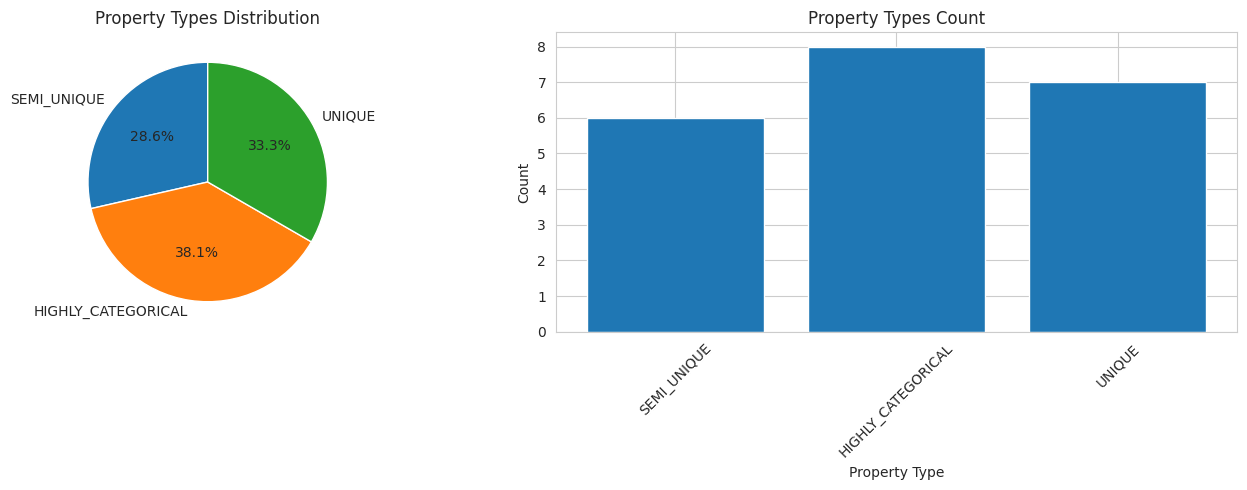

In [31]:
# Aggregate property types across all labels
property_type_counts = {}

for label, summary in all_results.items():
    for prop_name, prop_info in summary.items():
        prop_type = prop_info.get('type', 'UNKNOWN')
        if prop_type not in property_type_counts:
            property_type_counts[prop_type] = 0
        property_type_counts[prop_type] += 1

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
ax1.pie(property_type_counts.values(), labels=property_type_counts.keys(),
        autopct='%1.1f%%', startangle=90)
ax1.set_title('Property Types Distribution')

# Bar chart
ax2.bar(property_type_counts.keys(), property_type_counts.values())
ax2.set_xlabel('Property Type')
ax2.set_ylabel('Count')
ax2.set_title('Property Types Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
# Part 2: Weakly Connected Components (WCC)

**Algorithm**: WCC identifies groups of nodes that are connected to each other, even if the connections are indirect.

**Key Parameters:**
- `GRAPH_NAME`: Name of the GDS graph projection to analyze
- `USER_LABEL`: Node label to focus on (e.g., 'Stream')
- `PROPERTY_LABEL`: Related property nodes (e.g., 'Property')
- `REL_TYPE`: Relationship type connecting nodes (e.g., 'HAS')

**What it does:**
- Finds all connected components in the graph
- Assigns a `component_id` to each node
- Filters components with size > 1 (groups with multiple nodes)
- Writes `component_id_2` property to Stream nodes for downstream analysis

In [32]:
# WCC Configuration
# Graph projection settings - customize these based on your data
GRAPH_NAME = "stream-user-team-graph"
LABELS = ["Stream", "Team", "Game"]
REL_TYPES = ["VIP", "HAS_TEAM"]

# WCC-specific settings
# USER_LABEL = "Stream"  # The primary node label to analyze

print(f"Graph Projection Configuration:")
print(f"  Graph name: {GRAPH_NAME}")
print(f"  Node labels: {LABELS}")
print(f"  Relationship: {REL_TYPES})")
# print(f"\nWCC Analysis:")
# print(f"  Analyzing nodes: {USER_LABEL}")
# print(f"  Connected via: {REL_TYPE} -> {PROPERTY_LABEL}")

Graph Projection Configuration:
  Graph name: stream-user-team-graph
  Node labels: ['Stream', 'Team', 'Game']
  Relationship: ['VIP', 'HAS_TEAM'])


In [33]:
# Create Graph Projection (if it doesn't exist)
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

with driver:
    with driver.session() as session:
        # Check if graph already exists
        result = session.run(
            "CALL gds.graph.exists($name) YIELD exists RETURN exists",
            name=GRAPH_NAME
        )
        graph_exists = result.single()["exists"]

        if graph_exists:
            print(f"✅ Graph '{GRAPH_NAME}' already exists")

            # Optionally drop and recreate if you want to update the projection
            # Uncomment the following lines to recreate:
            # print(f"Dropping existing graph...")
            # session.run("CALL gds.graph.drop($name)", name=GRAPH_NAME)
            # graph_exists = False

        if not graph_exists:
            print(f"Creating graph projection '{GRAPH_NAME}'...")
            print(f"  Node labels: {LABELS}")
            print(f"  Relationship: {REL_TYPES})")

            # Build the relationship configuration dynamically
            # rel_config = {
            #     REL_TYPE: {
            #         "type": REL_TYPE,
            #         "orientation": REL_ORIENTATION
            #     }
            # }

            # Create the graph projection using Cypher projection
            session.run(
                "CALL gds.graph.project($name, $nodeLabels, $relConfig)",
                name=GRAPH_NAME,
                nodeLabels=LABELS,
                relConfig=REL_TYPES
            )

            print(f"✅ Graph projection '{GRAPH_NAME}' created successfully")

            # Show graph info
            info = session.run(
                "CALL gds.graph.list($name) "
                "YIELD graphName, nodeCount, relationshipCount "
                "RETURN graphName, nodeCount, relationshipCount",
                name=GRAPH_NAME
            ).single()

            if info:
                print(f"\n📊 Graph Statistics:")
                print(f"  Nodes: {info['nodeCount']:,}")
                print(f"  Relationships: {info['relationshipCount']:,}")

driver.close()

✅ Graph 'stream-user-team-graph' already exists


In [34]:
# Run WCC Algorithm
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

with driver:
    with driver.session() as session:
        # Step 1: Run WCC and write component IDs to nodes
        print("Running WCC algorithm and writing component_id_2 to nodes...")
        session.run(
            "CALL gds.wcc.stream($name) "
            "YIELD nodeId, componentId "
            "WITH gds.util.asNode(nodeId) AS n, componentId "
            "WHERE n:Stream "
            "WITH componentId, collect(n) AS nodes, count(*) AS size "
            "WHERE size > 1 "
            "UNWIND nodes AS n "
            "SET n.component_id_2 = componentId",
            name=GRAPH_NAME,
        )
        print("✅ Component IDs written to nodes")

        # Step 2: Query component statistics (one row per component)
        result = session.run(
            "CALL gds.wcc.stream($name) "
            "YIELD nodeId, componentId "
            "WITH gds.util.asNode(nodeId) AS n, componentId "
            "WHERE n:Stream "
            "WITH componentId, count(*) AS size "
            "WHERE size > 1 "
            "RETURN componentId, size "
            "ORDER BY size DESC, componentId ASC",
            name=GRAPH_NAME,
        )

        # Collect results (one row per component)
        wcc_results = []
        for record in result:
            wcc_results.append({
                'component_id': record['componentId'],
                'size': record['size']
            })

driver.close()

# Display results
wcc_df = pd.DataFrame(wcc_results)
print(f"\nFound {len(wcc_df)} connected components with size > 1")
print(f"Total nodes in components: {wcc_df['size'].sum():,}")
display(wcc_df.head(10))

Running WCC algorithm and writing component_id_2 to nodes...
✅ Component IDs written to nodes

Found 193 connected components with size > 1
Total nodes in components: 2,142


,component_id,size
0,1392,1473
1,19080,65
2,49905,24
3,41819,16
4,74162,14
5,28371,11
6,42596,11
7,51691,10
8,7306,9
9,23215,9


## 2.1 Visualize Component Size Distribution

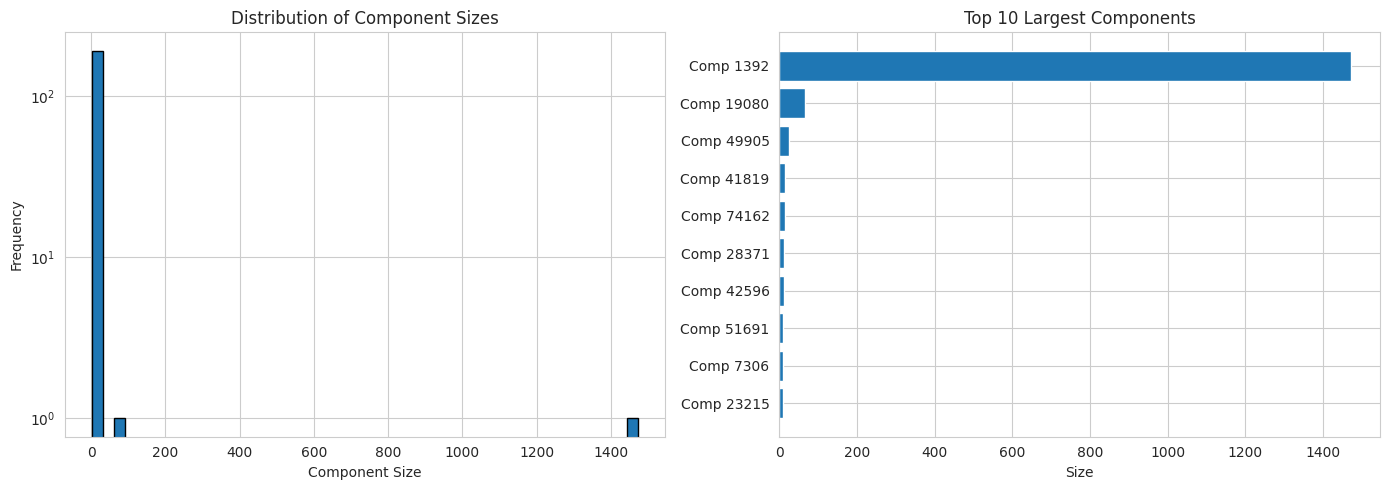


Component Statistics:
  Mean size: 11.10
  Median size: 2.00
  Largest component: 1,473 nodes
  Smallest component: 2 nodes


In [35]:
# Visualize component sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of component sizes
ax1.hist(wcc_df['size'], bins=50, edgecolor='black')
ax1.set_xlabel('Component Size')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Component Sizes')
ax1.set_yscale('log')

# Top 10 largest components
top_10 = wcc_df.nlargest(10, 'size')
ax2.barh(range(len(top_10)), top_10['size'])
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels([f"Comp {cid}" for cid in top_10['component_id']])
ax2.set_xlabel('Size')
ax2.set_title('Top 10 Largest Components')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nComponent Statistics:")
print(f"  Mean size: {wcc_df['size'].mean():.2f}")
print(f"  Median size: {wcc_df['size'].median():.2f}")
print(f"  Largest component: {wcc_df['size'].max():,} nodes")
print(f"  Smallest component: {wcc_df['size'].min():,} nodes")

---
# Part 3: Node Similarity

**Algorithm**: Node Similarity finds pairs of nodes that are similar based on their shared neighbors (Jaccard similarity).

**Key Parameters:**
- `GRAPH_NAME`: GDS graph projection (must include component_id_2 property)
- `NODE_LABELS`: Filter to specific node types (e.g., ['Stream'])
- `similarity > 0`: Only return node pairs with non-zero similarity

**What it does:**
- Compares nodes based on shared properties/neighbors
- Calculates Jaccard similarity: |A ∩ B| / |A ∪ B|
- Returns pairs of similar nodes with similarity scores
- Useful for finding potential duplicates or related entities

In [36]:
# Node Similarity Configuration
SIMILARITY_GRAPH_NAME = "stream-user-team-graph"
NODE_LABELS = ["Stream"]

print(f"Running Node Similarity on graph: {SIMILARITY_GRAPH_NAME}")
print(f"Analyzing node labels: {NODE_LABELS}")

Running Node Similarity on graph: stream-user-team-graph
Analyzing node labels: ['Stream']


In [37]:
# Run Node Similarity Algorithm
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

with driver:
    with driver.session() as session:
        result = session.run(
            "CALL gds.nodeSimilarity.stream($name, { "
            "  nodeLabels: $labels "
            "}) "
            "YIELD node1, node2, similarity "
            "WHERE similarity > 0 "
            "RETURN gds.util.asNode(node1).id AS node1_id, "
            "       gds.util.asNode(node1).component_id_2 AS node1_component_id, "
            "       gds.util.asNode(node2).id AS node2_id, "
            "       gds.util.asNode(node2).component_id_2 AS node2_component_id, "
            "       similarity "
            "ORDER BY similarity DESC "
            "LIMIT 1000",  # Limit for notebook display
            name=SIMILARITY_GRAPH_NAME,
            labels=NODE_LABELS,
        )

        # Collect results
        similarity_results = []
        for record in result:
            similarity_results.append({
                'node1_id': record['node1_id'],
                'node1_component': record['node1_component_id'],
                'node2_id': record['node2_id'],
                'node2_component': record['node2_component_id'],
                'similarity': record['similarity']
            })

driver.close()

# Display results
similarity_df = pd.DataFrame(similarity_results)
print(f"\nFound {len(similarity_df)} similar node pairs (showing top 1000)")
display(similarity_df.head(20))


Found 448 similar node pairs (showing top 1000)


,node1_id,node1_component,node2_id,node2_component,similarity
0,15027034,1392,419262873,1392,1.0
1,15027034,1392,530503592,1392,1.0
2,219621643,1392,120627272,1392,1.0
3,219621643,1392,91904840,1392,1.0
4,219621643,1392,138310362,1392,1.0
5,57317154,1392,39569560,1392,1.0
6,57317154,1392,56649026,1392,1.0
7,57317154,1392,26538483,1392,1.0
8,92372244,1392,58839113,1392,1.0
9,67519684,33729,147479110,33729,1.0


## 3.1 Visualize Similarity Distribution

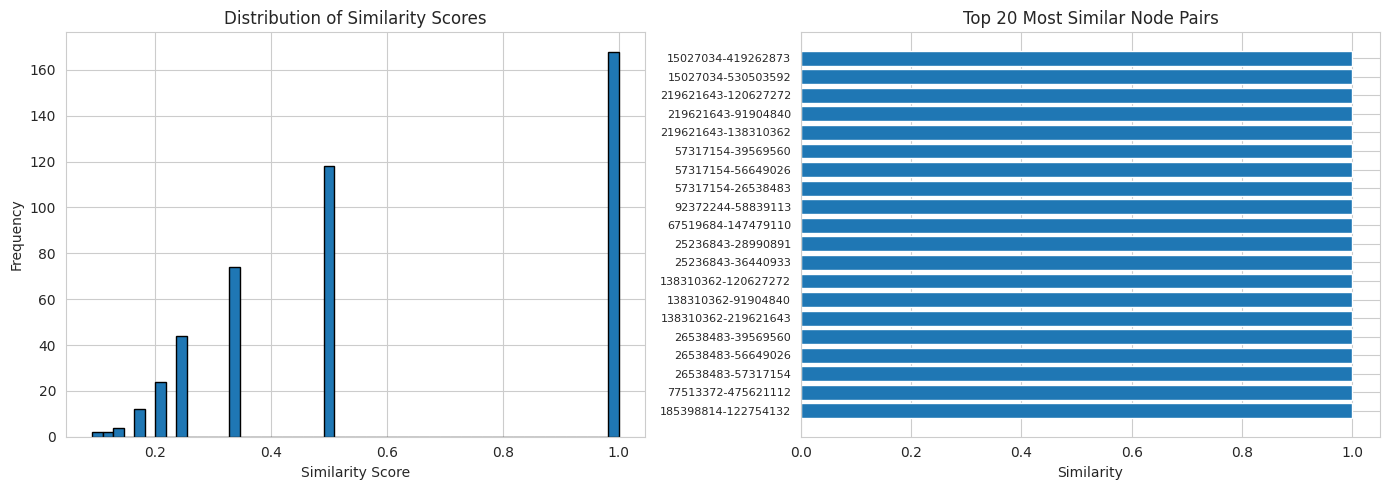


Similarity Statistics:
  Mean similarity: 0.6037
  Median similarity: 0.5000
  Max similarity: 1.0000
  Min similarity: 0.0909


In [38]:
# Visualize similarity scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of similarity scores
ax1.hist(similarity_df['similarity'], bins=50, edgecolor='black')
ax1.set_xlabel('Similarity Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Similarity Scores')

# Top 20 most similar pairs
top_20 = similarity_df.nlargest(20, 'similarity')
ax2.barh(range(len(top_20)), top_20['similarity'])
ax2.set_yticks(range(len(top_20)))
ax2.set_yticklabels([f"{row['node1_id']}-{row['node2_id']}" for _, row in top_20.iterrows()], fontsize=8)
ax2.set_xlabel('Similarity')
ax2.set_title('Top 20 Most Similar Node Pairs')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nSimilarity Statistics:")
print(f"  Mean similarity: {similarity_df['similarity'].mean():.4f}")
print(f"  Median similarity: {similarity_df['similarity'].median():.4f}")
print(f"  Max similarity: {similarity_df['similarity'].max():.4f}")
print(f"  Min similarity: {similarity_df['similarity'].min():.4f}")

---
# Part 4: Node Embeddings

**Algorithm**: FastRP (Fast Random Projection) creates vector representations of nodes, followed by KNN (K-Nearest Neighbors) to find similar nodes.

**Key Parameters:**
- `GRAPH_NAME`: GDS graph projection name
- `LABELS`: Node labels to include (e.g., ['Stream', 'Game'])
- `REL_TYPES`: Relationship types to consider (e.g., ['MODERATOR', 'VIP', 'CHATTER'])
- `embeddingDimension`: Size of embedding vectors (128)
- `topK`: Number of nearest neighbors to find (10)

**What it does:**
- Creates a graph projection filtered by component_id_2
- Generates 128-dimensional embeddings using FastRP
- Finds top 10 most similar nodes for each node using KNN
- Returns node pairs with similarity scores and component IDs

In [39]:
# Node Embeddings Configuration
EMBEDDING_GRAPH_NAME = "stream-user-team-graph"
EMBEDDING_LABELS = ["Stream", "Steam"]
EMBEDDING_DIMENSION = 128
TOP_K = 10

print(f"Running Node Embeddings on graph: {EMBEDDING_GRAPH_NAME}")
print(f"Node labels: {EMBEDDING_LABELS}")
print(f"Embedding dimension: {EMBEDDING_DIMENSION}")
print(f"Top K neighbors: {TOP_K}")

Running Node Embeddings on graph: stream-user-team-graph
Node labels: ['Stream', 'Steam']
Embedding dimension: 128
Top K neighbors: 10


In [40]:
# Run FastRP and KNN
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

with driver:
    with driver.session() as session:
        # Note: This assumes the graph projection and embeddings have been created
        # In practice, you would first create the projection and run FastRP
        # For this demo, we'll query the KNN results

        result = session.run(
            "CALL gds.knn.stream($name, { "
            "  nodeProperties: ['embedding'], "
            "  topK: $topK "
            "}) "
            "YIELD node1, node2, similarity "
            "RETURN gds.util.asNode(node1).id AS node1_id, "
            "       gds.util.asNode(node1).component_id_2 AS component_id_node_1, "
            "       gds.util.asNode(node2).id AS node2_id, "
            "       gds.util.asNode(node2).component_id_2 AS component_id_node_2, "
            "       similarity "
            "ORDER BY similarity DESC "
            "LIMIT 1000",
            name=EMBEDDING_GRAPH_NAME,
            topK=TOP_K,
        )

        # Collect results
        embedding_results = []
        for record in result:
            embedding_results.append({
                'node1_id': record['node1_id'],
                'component_id_1': record['component_id_node_1'],
                'node2_id': record['node2_id'],
                'component_id_2': record['component_id_node_2'],
                'similarity': record['similarity']
            })

driver.close()

# Display results
embedding_df = pd.DataFrame(embedding_results)
print(f"\nFound {len(embedding_df)} embedding-based similar pairs (showing top 1000)")
display(embedding_df.head(20))

ClientError: {neo4j_code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.knn.stream`: Caused by: java.lang.IllegalArgumentException: The property `embedding` has not been loaded. Available properties: []} {gql_status: 52N37} {gql_status_description: error: procedure exception - procedure execution error. Execution of the procedure gds.knn.stream() failed.}

## 4.1 Visualize Embedding-Based Similarity

In [ ]:
# Visualize embedding similarity scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of embedding similarity scores
ax1.hist(embedding_df['similarity'], bins=50, edgecolor='black', alpha=0.7, label='Embeddings')
if len(similarity_df) > 0:
    ax1.hist(similarity_df['similarity'], bins=50, edgecolor='black', alpha=0.5, label='Node Similarity')
ax1.set_xlabel('Similarity Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Comparison: Embedding vs Node Similarity')
ax1.legend()

# Component distribution in embedding results
component_counts = embedding_df['component_id_1'].value_counts().head(10)
ax2.barh(range(len(component_counts)), component_counts.values)
ax2.set_yticks(range(len(component_counts)))
ax2.set_yticklabels([f"Comp {cid}" for cid in component_counts.index])
ax2.set_xlabel('Number of Similar Pairs')
ax2.set_title('Top 10 Components by Similar Pairs')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nEmbedding Similarity Statistics:")
print(f"  Mean similarity: {embedding_df['similarity'].mean():.4f}")
print(f"  Median similarity: {embedding_df['similarity'].median():.4f}")
print(f"  Max similarity: {embedding_df['similarity'].max():.4f}")
print(f"  Min similarity: {embedding_df['similarity'].min():.4f}")

---
# Summary

This notebook demonstrated a complete graph analysis pipeline:

1. **EDA**: Explored the graph structure, node labels, and property distributions
2. **WCC**: Identified connected components and assigned component_id_2 to nodes
3. **Node Similarity**: Found similar nodes based on Jaccard similarity of shared neighbors
4. **Node Embeddings**: Created vector representations and found similar nodes using KNN

## Key Findings:
- Component IDs help group related nodes together
- Node similarity captures structural similarity based on shared connections
- Embeddings capture deeper semantic relationships in the graph
- Both approaches complement each other for comprehensive similarity analysis